# Setup

In [1]:
%load_ext autoreload
%autoreload 2

import crispr as cr 
from crispr.crispr_class import Crispr
import pertpy as pt
import muon
import os
import pandas as pd
import numpy as np
from config import (files_data, col_cell_type_data, col_gene_symbols_data, 
                    assays_data, layer_perturbation_data,
                    col_perturbation_data, key_control_data, 
                    col_split_by_data, layer_perturbation_data,
                    col_target_genes_data, key_nonperturbed_data,
                    key_treatment_data, col_guide_rna_data, col_batch_data,
                    col_sample_id_data, kws_process_guide_rna_data)

# Options
skip_preprocessing_clustering = False  # to skip these steps
print(dir(cr.ax))
file = "CRISPRi_scr"
# file = "CRISPRi_ess"
# file = "ECCITE"
# file = "augur_ex"
# file = "coda"
# file = "screen"
# file = "perturb-seq"
kws_pca = dict(n_comps=None, use_highly_variable=True)
kws_neighbors = None  # passed to neighbors function
kws_umap = dict(min_dist=0.3)  # passed to UMAP fx
kws_cluster = dict(resolution=0.5)  # passed to louvain/leiden fx

#  Set Arguments
if file in assays_data:
    if isinstance(assays_data[file], str) or assays_data[file] is None:
        assays_data[file] = [assays_data[file], None]
    assay, assay_protein = assays_data[file]
else:
    assay, assay_protein = None
file_path = files_data[file]
kws_process_guide_rna = kws_process_guide_rna_data[file]
col_split_by = col_split_by_data[file]
kwargs_init = dict(assay=assay, assay_protein=assay_protein,
                   col_gene_symbols=col_gene_symbols_data[file],  
                   col_cell_type=col_cell_type_data[file], 
                   col_sample_id=col_sample_id_data[file], 
                   col_batch=col_batch_data[file],
                   col_perturbation=col_perturbation_data[file], 
                   col_guide_rna=col_guide_rna_data[file], 
                   col_target_genes=col_target_genes_data[file], 
                   layer_perturbation=layer_perturbation_data[file],
                   key_nonperturbed=key_nonperturbed_data[file],
                   key_control=key_control_data[file], 
                   key_treatment=key_treatment_data[file])
print(files_data)
if file == "default_fast":
    skip_preprocessing_clustering = True

['__builtins__', '__cached__', '__doc__', '__file__', '__loader__', '__name__', '__package__', '__path__', '__spec__', 'analyze_composition', 'cluster', 'clustering', 'compute_distance', 'perform_augur', 'perform_differential_prioritization', 'perform_mixscape', 'perturbations']
{'CRISPRi_scr': {'directory': '/home/asline01/projects/crispr/examples/data/crispr-screening/HH03'}, 'CRISPRi_wgs': '/home/asline01/projects/crispr/examples/data/replogle_2022_k562_gwps.h5ad', 'CRISPRi_ess': '/home/asline01/projects/crispr/examples/data/replogle_2022_k562_esss.h5ad', 'pool': '/home/asline01/projects/crispr/examples/data/norman_2019_raw.h5ad', 'bulk': '/home/asline01/projects/crispr/examples/data/burczynski_crohn.h5ad', 'screen': '/home/asline01/projects/crispr/examples/data/dixit_2016_raw.h5ad', 'perturb-seq': '/home/asline01/projects/crispr/examples/data/adamson_2016_upr_perturb_seq.h5ad', 'ECCITE': '/home/asline01/projects/crispr/examples/data/papalexi_2021.h5ad', 'coda': '/home/asline01/proj

# Setup Object

## Instantiate

This code looks more complicated than it actually would actually be for an end user because it was made to be generalizable across several datasets with particular column names, sizes that make it necessary to subset them in order to run the vignettes in a reasonable period of time, etc.

Note that we are passing an AnnData Scanpy object because there are specific manipulations made to certain public datasets in the config.load_example_data function
meant to decrease computation time/memory usage, etc.

End users can simply pass to the `file` argument of `Crispr()` a 10x CellRanger output directory (or a dictionary of appropriate protospacer-related arguments if perturbation-related data aren't included in the .mtx file; see the `Crispr.preprocessing.combine_matrix_protospacer()` function for details) or .h5ad file if desired.

In [2]:
# Initialize Object
print(f"Initialization keyword arguments (from config):\n{kwargs_init}")
if isinstance(file, str) and file in ["ECCITE", "Adamson"]:
    self = Crispr(
        pt.data.papalexi_2021() if file == "ECCITE" else
        pt.data.adamson_2016_upr_perturb_seq(), **kwargs_init)
else:
    self = Crispr(file_path, **kwargs_init)
        
# Print
print(self.adata.obs, "\n\n") if assay else None
print(f"\n\n{self._columns}\n\n{self._keys}\n\n")
self.adata[assay].obs if assay else self.adata.obs

Initialization keyword arguments (from config):
{'assay': None, 'assay_protein': None, 'col_gene_symbols': 'gene_symbols', 'col_cell_type': 'leiden', 'col_sample_id': None, 'col_batch': None, 'col_perturbation': 'name', 'col_guide_rna': 'feature_call', 'col_target_genes': 'target_gene_name', 'layer_perturbation': nan, 'key_nonperturbed': 'NP', 'key_control': 'NT', 'key_treatment': 'Perturbed'}
<<<

CREATING OBJECT>>>


 AnnData object with n_obs × n_vars = 15078 × 36601
    obs: 'num_features', 'feature_call', 'num_umis'
    var: 'gene_ids', 'feature_types'


{'col_gene_symbols': 'gene_symbols', 'col_cell_type': 'leiden', 'col_sample_id': None, 'col_batch': None, 'col_perturbation': 'name', 'col_guide_rna': 'feature_call', 'col_target_genes': 'target_gene_name'}

{'key_control': 'NT', 'key_treatment': 'Perturbed', 'key_nonperturbed': 'NP'}




,num_features,feature_call,num_umis
AAACCCAAGAATTTGG-1,6.0,RASGRP1-1|PAF1-1|NEG_CTRL-2-1|NRBP1-2|RASGRP1-...,10|19|55|4|9|18
AAACCCAAGATTTGCC-1,2.0,SNX17-1|SNX17-2,200|33
AAACCCAAGCGATTCT-1,3.0,SP110-1|HLA-B-1|SP140L-2,12|22|7
AAACCCAAGTCGGGAT-1,NaN,NaN,NaN
AAACCCAAGTCTGCAT-1,6.0,RSBN1-1|PRDX6-1|STK11-1|RSBN1-2|PRDX6-2|NR4A1-2,194|381|51|513|119|47
...,...,...,...
TTTGTTGGTTGCCGAC-1,4.0,DUSP1-1|PPARA-1|TAGAP-2|DUSP1-2,48|19|4|46
TTTGTTGTCACTGTTT-1,2.0,ATG16L1-1|GPX4-1,73|125
TTTGTTGTCAGACCCG-1,NaN,NaN,NaN
TTTGTTGTCAGTGTGT-1,5.0,HLA-B-1|TMEM50B-1|DUSP1-1|DUSP1-2|RUNX3-P2-2,188|168|35|9|47


## Preprocess and Cluster

See `self.figures[run_label]["clustering"]` (object attribute) or method output for figures.

You must set use_highly_variable to False if you don't want to filter by HVGs
and if you did not set kws_hvg to None or False in `.preprocess()`


In that scenario, the 'highly_variable' column in  will be created in `.obsm` 
during `.preprocess()` and then used by default in `.cluster`.

UMAP Keywords: {'min_dist': 0.3}
AnnData object with n_obs × n_vars = 15078 × 36601
    obs: 'num_features', 'feature_call', 'num_umis', 'Perturbed_RASGRP1', 'Perturbed_PAF1', 'Perturbed_NT', 'Perturbed_NRBP1', 'Perturbed_SNX17', 'Perturbed_SP110', 'Perturbed_HLA', 'Perturbed_SP140L', 'Perturbed_NP', 'Perturbed_RSBN1', 'Perturbed_PRDX6', 'Perturbed_STK11', 'Perturbed_NR4A1', 'Perturbed_WSB1', 'Perturbed_PDPN', 'Perturbed_IFNGR2', 'Perturbed_TAGAP', 'Perturbed_CRYZL1', 'Perturbed_MYD88', 'Perturbed_SPI1', 'Perturbed_IFNAR2', 'Perturbed_IL10RB', 'Perturbed_PTPN22', 'Perturbed_INPP5D', 'Perturbed_DUSP1', 'Perturbed_RUNX3', 'Perturbed_TMEM50B', 'Perturbed_LGALS9', 'Perturbed_KSR1', 'Perturbed_POLR2E', 'Perturbed_IL6ST', 'Perturbed_HIPK1', 'Perturbed_PPARA', 'Perturbed_GPX4', 'Perturbed_NOD2', 'Perturbed_CEBPB', 'Perturbed_ABCA7', 'Perturbed_LACC1', 'Perturbed_MAFB', 'Perturbed_ZFP36', 'Perturbed_SP100', 'Perturbed_CSF1R', 'Perturbed_IRF8', 'Perturbed_RIPK2', 'Perturbed_SNX20', 'Perturbed_A

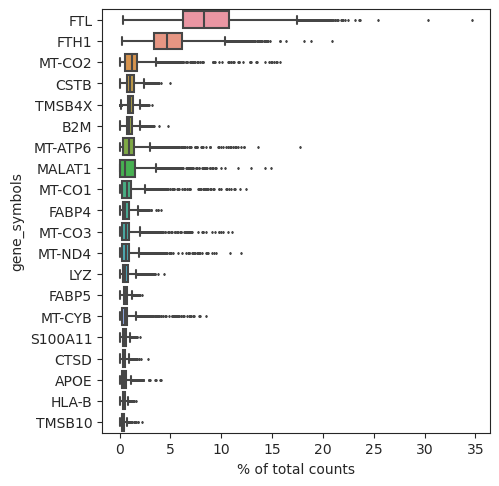


<<< FILTERING >>>

<<< DETECTING MITOCHONDRIAL GENES >>>

<<< PERFORMING QUALITY CONTROL >>>


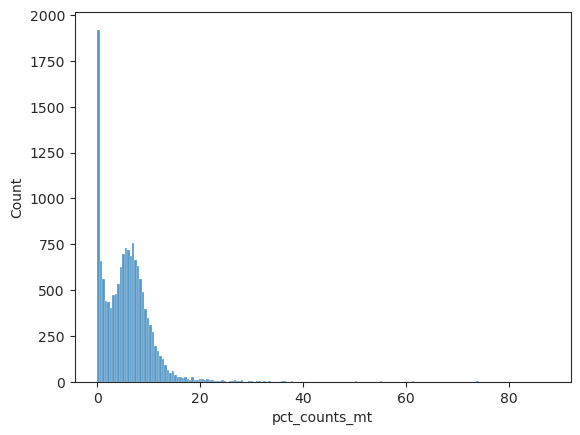

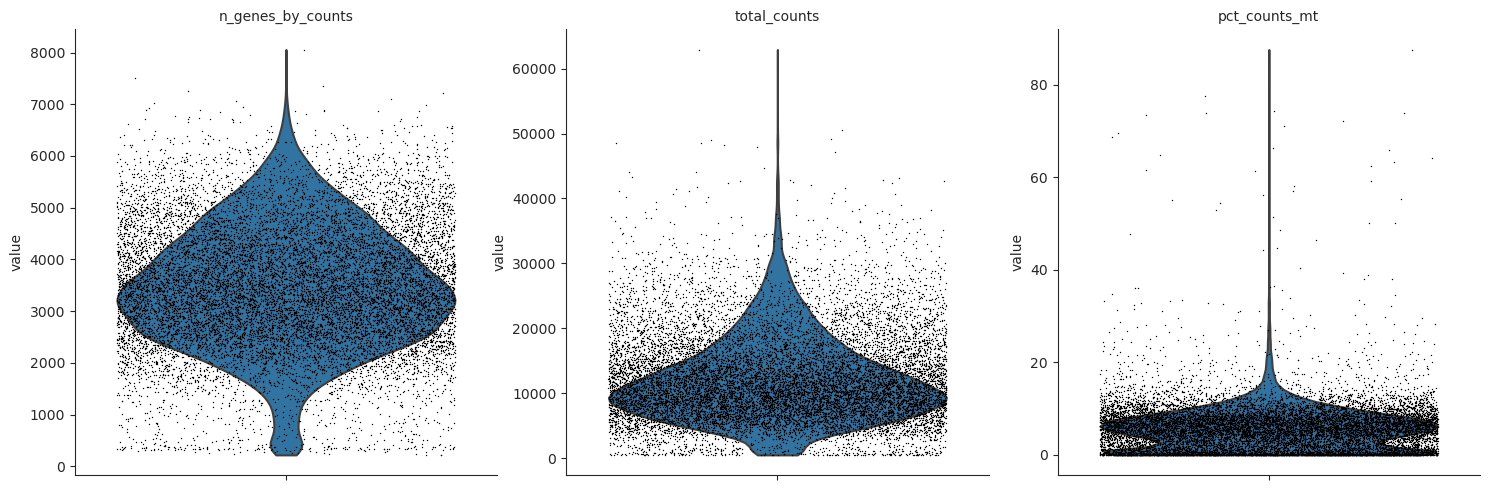

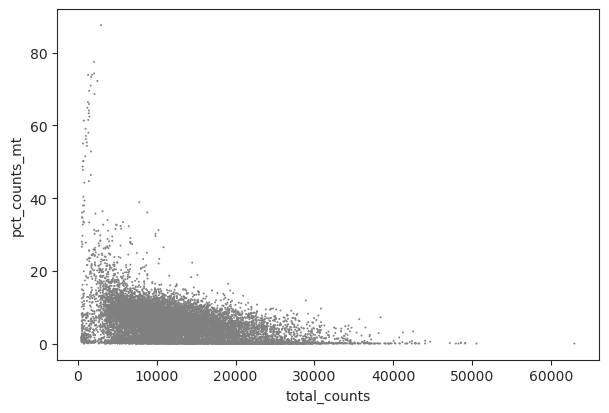

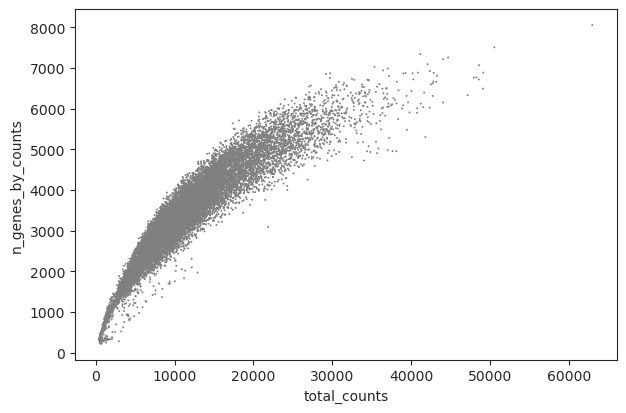


<<< NORMALIZING >>>

<<< DETECTING VARIABLE GENES >>>

<<< SCALING >>>



Un-used Keyword Arguments: {'col_gene_symbols': 'gene_symbols', 'col_cell_type': 'leiden', 'col_sample_id': None, 'col_batch': None, 'col_perturbation': 'name', 'col_guide_rna': 'feature_call', 'col_target_genes': 'target_gene_name', 'key_control': 'NT', 'key_treatment': 'Perturbed', 'key_nonperturbed': 'NP'}


<<< PERFORMING PCA >>>

 {'n_comps': None, 'use_highly_variable': True}


<<< COMPUTING NEIGHBORHOOD GRAPH >>>


<<< EMBEDDING: UMAP >>>

 {'min_dist': 0.3}


<<< CLUSTERING WITH LEIDEN METHOD >>>


<<< CREATING UMAP PLOTS >>>


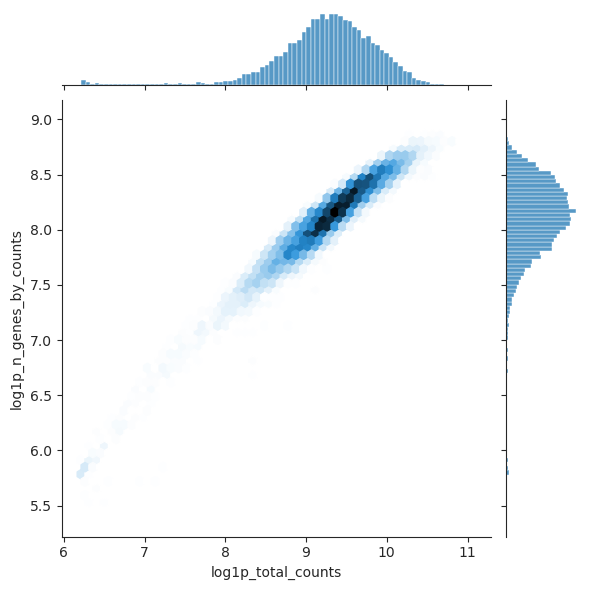

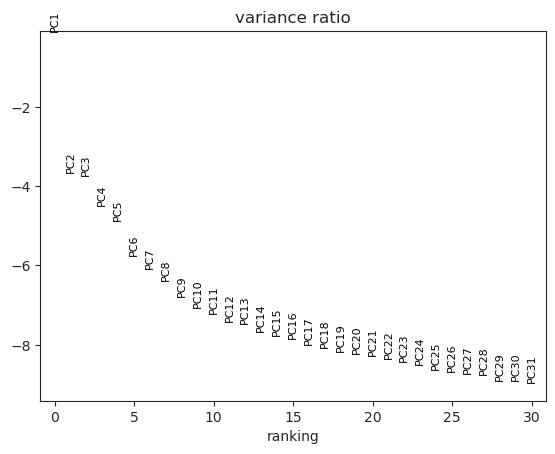

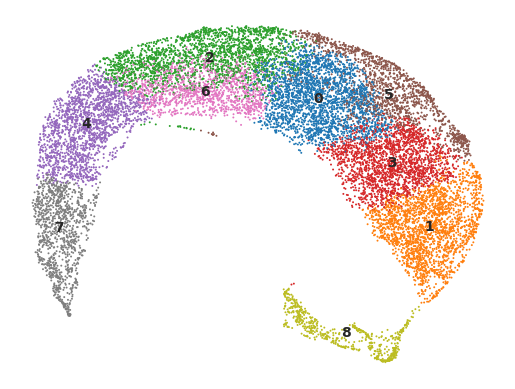

,num_features,feature_call,num_umis,Perturbed_RASGRP1,Perturbed_PAF1,Perturbed_NT,Perturbed_NRBP1,Perturbed_SNX17,Perturbed_SP110,Perturbed_HLA,...,name,n_genes,n_genes_by_counts,log1p_n_genes_by_counts,total_counts,log1p_total_counts,total_counts_mt,log1p_total_counts_mt,pct_counts_mt,leiden
AAACCCAAGAATTTGG-1,6.0,RASGRP1-1|PAF1-1|NEG_CTRL-2-1|NRBP1-2|RASGRP1-...,10|19|55|4|9|18,Perturbed,Perturbed,Perturbed,Perturbed,NT,NT,NT,...,Perturbed,2392,2392,7.780303,7285.0,8.893710,373.0,5.924256,5.120110,0
AAACCCAAGATTTGCC-1,2.0,SNX17-1|SNX17-2,200|33,NT,NT,NT,NT,Perturbed,NT,NT,...,Perturbed,4762,4762,8.468633,17575.0,9.774290,1045.0,6.952729,5.945946,6
AAACCCAAGCGATTCT-1,3.0,SP110-1|HLA-B-1|SP140L-2,12|22|7,NT,NT,NT,NT,NT,Perturbed,Perturbed,...,Perturbed,6456,6456,8.772920,38373.0,10.555136,2782.0,7.931285,7.249889,4
AAACCCAAGTCGGGAT-1,NaN,NaN,NaN,NP,NP,NP,NP,NP,NP,NP,...,NP,2060,2060,7.630947,4820.0,8.480737,471.0,6.156979,9.771785,1
AAACCCAAGTCTGCAT-1,6.0,RSBN1-1|PRDX6-1|STK11-1|RSBN1-2|PRDX6-2|NR4A1-2,194|381|51|513|119|47,NT,NT,NT,NT,NT,NT,NT,...,Perturbed,4243,4243,8.353261,14886.0,9.608244,220.0,5.398163,1.477899,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TTTGTTGGTTGCCGAC-1,4.0,DUSP1-1|PPARA-1|TAGAP-2|DUSP1-2,48|19|4|46,NT,NT,NT,NT,NT,NT,NT,...,Perturbed,3800,3800,8.243019,10459.0,9.255314,367.0,5.908083,3.508940,5
TTTGTTGTCACTGTTT-1,2.0,ATG16L1-1|GPX4-1,73|125,NT,NT,NT,NT,NT,NT,NT,...,Perturbed,3181,3181,8.065265,11869.0,9.381769,699.0,6.551080,5.889291,2
TTTGTTGTCAGACCCG-1,NaN,NaN,NaN,NP,NP,NP,NP,NP,NP,NP,...,NP,1063,1063,6.969791,1623.0,7.392648,5.0,1.791759,0.308071,8
TTTGTTGTCAGTGTGT-1,5.0,HLA-B-1|TMEM50B-1|DUSP1-1|DUSP1-2|RUNX3-P2-2,188|168|35|9|47,NT,NT,NT,NT,NT,NT,Perturbed,...,Perturbed,3998,3998,8.293800,13419.0,9.504501,671.0,6.510258,5.000372,6


In [3]:
if skip_preprocessing_clustering is False:  # if not already processed & clustered
    
    # Arguments
    print(f"UMAP Keywords: {kws_umap}")
    # Preprocess
    process_kws = dict(kws_hvg=dict(min_mean=0.0125, max_mean=3, min_disp=0.5),
                       target_sum=1e4, max_genes_by_counts=2500, max_pct_mt=15,
                       min_genes=200, min_cells=3, scale=10, regress_out=None,
                       kws_process_guide_rna=kws_process_guide_rna)
    self.preprocess(**process_kws, kws_umap=kws_umap)  # preprocessing
    
    # Cluster 
    self.cluster(method_cluster="leiden", kws_neighbors=kws_neighbors,
                 kws_pca=kws_pca, kws_umap=kws_umap,  kws_cluster=kws_cluster)
self.adata.obs

## Inspect & Set Up Arguments for Later

You won't need this code as an end user; this is just to choose relevant random subsets of genes, perturbations, etc. that are available in a given example dataset, for illustration purposes (and to conserve memory/time by not using every gene/condition/etc.). 

In real use cases, you will know what genes and conditions are of interest, and you can manually specify them by simply stating them in the appropriate arguments (such as `target_gene_idents`) or (in many cases) by not specifying the argument (resulting in the code using all available genes, etc.).

In [5]:
# Choose Subset of Sequenced Genes
genes = np.array((self.adata[assay] if assay else self.adata).var.reset_index(
    )[self._columns["col_gene_symbols"]].copy())
genes_subset = list(pd.Series(genes).sample(10))

# Choose Subset of Target Genes
tga = (self.adata[assay] if assay else self.adata).obs[
    self._columns["col_target_genes"]].copy().unique()
# tga = list(pd.Series(tga)[pd.Series(tga).apply(
#     lambda t: sum((self.adata[assay].obs if assay else self.adata.obs)[
#         self._columns["col_target_genes"]] == t) > 3)])  # sufficient N
if file == "CRISPRi_scr":
    target_gene_idents = list(pd.Series(tga).dropna()[[
        ("ATGL1" in x or "CDKN2A" in x or "PLAUR" in x or "NOD2" in x) and (
            len(x.split("|")) < 3) for x in pd.Series(tga).dropna()]])
else:
    target_gene_idents = list(pd.Series(tga).sample(3)) if len(tga) > 3 else True
print(f"\n\nGene Subset: {', '.join(list(genes_subset))}\n\n")
print(f"Targets: {target_gene_idents}")

# # Mixscape Subset
# subset_mixscape = (self.adata[assay] if assay else self.adata).obs.num_features < 2

# Perturbation Categories
(self.adata[assay] if assay else self.adata).obs[
    self._columns["col_perturbation"]]



Gene Subset: AC005920.1, SMIM2-IT1, AC009120.2, AC027796.4, IPMK, POLR3C, SLC25A29, WDR75, AL360091.2, LSMEM1


Targets: ['NOD2', 'NOD2|NOD2', 'NOD2|RIPK2', 'NOD2|PAF1', 'NOD2|NT', 'NOD2|CRYZL1', 'NOD2|PPARA', 'NOD2|RSBN1', 'NOD2|FASLG', 'CSF1R|NOD2', 'PPARA|NOD2', 'MYD88|NOD2', 'NOD2|PHTF1', 'POLR2E|NOD2', 'SP100|NOD2', 'NOD2|DUSP1', 'IL6ST|NOD2', 'NOD2|IFNAR2', 'MAFB|NOD2', 'RPN1|NOD2', 'INPP5D|NOD2', 'NOD2|PDPN', 'ABCA7|NOD2', 'NOD2|LGALS9', 'WSB1|NOD2', 'NOD2|IL10RB', 'SP110|NOD2', 'NOD2|IRF8', 'NOD2|SP140L', 'PPM1G|NOD2', 'NOD2|SP100', 'NOD2|MYD88', 'RPN2|NOD2', 'NOD2|LACC1', 'HIPK1|NOD2']


AAACCCAAGAATTTGG-1    Perturbed
AAACCCAAGATTTGCC-1    Perturbed
AAACCCAAGCGATTCT-1    Perturbed
AAACCCAAGTCGGGAT-1           NP
AAACCCAAGTCTGCAT-1    Perturbed
                        ...    
TTTGTTGGTTGCCGAC-1    Perturbed
TTTGTTGTCACTGTTT-1    Perturbed
TTTGTTGTCAGACCCG-1           NP
TTTGTTGTCAGTGTGT-1    Perturbed
TTTGTTGTCCACGTCT-1           NP
Name: name, Length: 15078, dtype: category
Categories (3, object): ['NP', 'NT', 'Perturbed']

## Basic Plots

In [ ]:
figs = self.plot(genes=genes_subset, layers="all", 
                 kws_gex_violin=dict(scale="area", figsize=(15, 15)))

# Analyses

## Augur: Cell Type-Level Perturbation Response

Which cell types are most affected by perturbations? Quantify perturbation responses by cell type with Augur, which uses supervised machine learning classification of experimental condition labels (e.g., treated versus untreated). The more separable the condition among cells of a given type, the higher the perturbation effect score.

<u> __Features__ </u>  

- Quantify and visualize degree of perturbation response by cell type

<u> __Input__ </u>  

<u> __Output__ </u>  

mean_augur_score

<u> __Notes__ </u>  

- col_perturbation + "_binary"
- Sub-sample sizes equal across conditions; does not account for perturbation-induced compositional shifts (cell type abundance)
- Scores are for cell types (aggregated across cells, not individual cells)
- Two modes
    - If select_variance_feature=True, run the original Augur implementation, which removes genes that don't vary much across cell type.
    - If False, use features selected by `scanpy.pp.highly_variable_genes()`, which is faster and sensitively recovers effects; however, the feature selection may yield inflated Augur scores because this reduced feature set is used in training, resulting in it taking advantage of the pre-existing power of this feature selection to separate cell types.
    - If False, you also have to be sure that "highly_variable_features" is a variable in your data. This can be complicated if you have a separate layer for perturbation data.

In [ ]:
augur_data, augur_results, figs_augur = self.run_augur(
    col_perturbation=self._columns["col_perturbation"], 
    key_treatment=self._keys["key_treatment"], 
    classifier="random_forest_classifier", n_threads=True,
    augur_mode="default", select_variance_features=True, n_folds=2,
    kws_umap=kws_umap, subsample_size=20, kws_augur_predict=dict(span=0.5))

## Mixscape: Cell-Level Perturbation Response

**Which cell types are most affected by perturbations?** Quantify perturbation responses by cell type with Augur, which uses supervised machine learning classification of condition labels (e.g., treated versus untreated) and looking at how easy it is to tell perturbed versus non-perturbed (more separable = higher effect).

**Are there perturbation-specific clusters?** Mixscape uses linear discriminant analysis (LDA) to cluster cells that resemble each other in terms of gene expression and perturbation condition. _(LDA reduces dimensionality and attempts to maximize the separability of classes. Unperturbed cells are removed from analysis.)_

<u> __Features__ </u>  

- Remove confounds (e.g., cell cycle, batch effects)
- Classify cells as affected or unaffected (i.e., "escapees") by the perturbation
- Quantify and visualize degree of perturbation response

<u> __Input__ </u>  

<u> __Output__ </u>  
- Mixscape figures

<u> __Notes__ </u>  


In [ ]:
# mixscape_identifier = pt.tl.Mixscape()
# mixscape_identifier.perturbation_signature(self.adata, self._columns["col_perturbation"], self._keys["key_control"])
# adata_pert = self.adata[self.adata.obs[self._columns[
#     "col_perturbation"]].isin([self._keys["key_treatment"], self._keys["key_control"]])].copy()
# adata_pert.X = adata_pert.layers["X_pert"]
# mixscape_identifier.mixscape(adata=adata_pert, 
#                 # adata=adata_pert,
#                 labels=self._columns["col_target_genes"], control=self._keys["key_control"], 
#                 layer="X_pert",
#                 perturbation_type=self._keys["key_treatment"])  # Mixscape classification
# mixscape_identifier.lda(adata=adata_pert, 
#         # adata=adata_pert,
#         labels=self._columns["col_target_genes"], 
#         layer="X_pert", control=self._keys["key_control"], 
#         split_by=col_split_by, 
#         perturbation_type=self._keys["key_treatment"],
#         mixscape_class_global="mixscape_class_global")  # linear discriminant analysis (LDA)

In [6]:
figs_mixscape = self.run_mixscape(target_gene_idents=target_gene_idents,
                                  col_split_by=col_split_by)


Un-used Keyword Arguments: {'col_gene_symbols': 'gene_symbols', 'col_cell_type': 'leiden', 'col_sample_id': None, 'col_batch': None, 'label_perturbation_type': 'Perturbed'}


## Distance Metrics

See `self.figures[run_label]["distances"]` and  `self.results[run_label]["distances"]`
for results.

In [ ]:
fig_distance = self.compute_distance(
    subset=self.adata.obs[self._columns["col_target_genes"]].isin(
        [self._keys["key_control"], self._keys["key_nonperturbed"]
         ] + target_gene_idents),  # subset for quickness
    distance_type="edistance", method="X_pca")